This notebook highlights the most commonly exchanged bacteria between the lungs and oropharynx and lungs and stomach.

It also builds classifiers based on these exchanged OTUs alone.

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from scipy.stats import fisher_exact

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import os, sys
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.append(src_dir)
from util import cv_and_roc, plot_auc_from_list, tidyfy_otu, convert_to_latex

/Users/claire/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Which are the most differentially exchanged OTUs?

In [3]:
fpreva = '../../data/analysis/prevalence.partial_corrs.nthresh10-qthresh01-rthresh0.txt'
preva = pd.read_csv(fpreva, sep='\t')
preva.head()

,otu,prevalence_exchange,meta_var,meta_val,site_comparison,n_patients
0,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo364,0.237705,all_patients,all_patients,bal-gastric_fluid,122
1,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.147541,all_patients,all_patients,bal-gastric_fluid,122
2,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.139344,all_patients,all_patients,bal-gastric_fluid,122
3,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.393443,all_patients,all_patients,bal-gastric_fluid,122
4,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.180328,all_patients,all_patients,bal-gastric_fluid,122


In [4]:
# Number of exchange OTUs per site combination
preva.query('meta_var == "all_patients"').groupby('site_comparison').size()

site_comparison
bal-gastric_fluid            48
bal-throat_swab               9
gastric_fluid-throat_swab    98
dtype: int64

In [5]:
# Let's look just at the aspirator vs. non-aspirator comparisons
preva = preva.query('meta_var == "mbs_consolidated"')

# And just the bal-throat_swab comparison
preva = preva.query('site_comparison == "bal-throat_swab"')

In [6]:
diffpreva = preva.pivot(index='otu', columns='meta_val', values='prevalence_exchange')
diffpreva['asp_minus_nml'] = diffpreva['Aspiration/Penetration'] - diffpreva['Normal']
diffpreva['abs_diff'] = abs(diffpreva['asp_minus_nml'])

In [7]:
diffpreva.sort_values(by='abs_diff', ascending=False)

meta_val,Aspiration/Penetration,Normal,asp_minus_nml,abs_diff
otu,,,,
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__;s__;d__denovo93,0.428571,0.066667,0.361905,0.361905
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo8,0.642857,0.300000,0.342857,0.342857
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo13,0.678571,0.366667,0.311905,0.311905
k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Veillonellaceae;g__Veillonella;s__;d__denovo26,0.571429,0.266667,0.304762,0.304762
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo323,0.392857,0.133333,0.259524,0.259524
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo100,0.321429,0.100000,0.221429,0.221429
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo213,0.321429,0.133333,0.188095,0.188095
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo287,0.178571,0.100000,0.078571,0.078571
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__;s__;d__denovo37,0.321429,0.366667,-0.045238,0.045238


In [8]:
# How many patients were used for these prevalence calcs?
preva[['meta_val', 'n_patients']].drop_duplicates()

,meta_val,n_patients
825,Aspiration/Penetration,28
834,Normal,30


In [9]:
## Do some text manipulations to print these values out in latex table format

# Split OTU names to individual phyla
table = pd.concat((diffpreva.reset_index(), diffpreva.reset_index()['otu'].str.split(';', expand=True)), axis=1)
table['family'] = table[4].str.split('f__').str[1]
table['genus'] = table[5].str.split('g__').str[1]
# Re-format percentages
table['Aspiration/Penetration'] = table['Aspiration/Penetration'].apply(lambda x: '{:.1f}'.format(x*100))
table['Normal'] = table['Normal'].apply(lambda x: '{:.1f}'.format(x*100))
table['Difference'] = table['asp_minus_nml'].apply(lambda x: '{:.1f}'.format(x*100))
table = table.sort_values(by='asp_minus_nml', ascending=False)

col_order = ['family', 'genus', 'Aspiration/Penetration', 'Normal', 'Difference']
table = table[col_order]
print('\n'.join(table.apply(convert_to_latex, axis=1)))

Flavobacteriaceae &  & 42.9 & 6.7 & 36.2 \\ 
Fusobacteriaceae & Fusobacterium & 64.3 & 30.0 & 34.3 \\ 
Porphyromonadaceae & Porphyromonas & 67.9 & 36.7 & 31.2 \\ 
Veillonellaceae & Veillonella & 57.1 & 26.7 & 30.5 \\ 
Streptococcaceae & Streptococcus & 39.3 & 13.3 & 26.0 \\ 
Fusobacteriaceae & Fusobacterium & 32.1 & 10.0 & 22.1 \\ 
Prevotellaceae & Prevotella & 32.1 & 13.3 & 18.8 \\ 
Porphyromonadaceae & Porphyromonas & 17.9 & 10.0 & 7.9 \\ 
Pasteurellaceae &  & 32.1 & 36.7 & -4.5 \\ 


# Classify aspirator from non-aspirator with BAL-throat OTUs

In [10]:
# Define some global variables
random_state = 1234
aspdict = {'Normal': 0, 'Aspiration/Penetration': 1}

In [11]:
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'
fmeta = '../../data/clean/rosen.metadata.clean'

otu = pd.read_csv(fotu, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)

In [12]:
keepotus = diffpreva.index.tolist()
otu = otu[keepotus]

In [13]:
# Grab patients with both BAL and throat swab, and aspiration status
sites = ['bal', 'throat_swab']
patientsamples = meta\
    .query('site == @sites')\
    .dropna(subset=['mbs_consolidated'])\
    .groupby(['mbs_consolidated', 'site', 'subject_id'])\
    .size()\
    .to_frame('n_samples')\
    .reset_index()\
    .groupby(['subject_id', 'mbs_consolidated'])\
    .size()\
    .to_frame('n_samples')\
    .reset_index()
patientsamples = patientsamples.query('n_samples == 2')
#patientsamples.head()

In [14]:
h_subjs = patientsamples\
    .query('mbs_consolidated == "Normal"')\
    ['subject_id'].tolist()
asp_subjs = patientsamples\
    .query('mbs_consolidated == "Aspiration/Penetration"')\
    ['subject_id'].tolist()

## Asp vs. non-asp, BAL microbiome, bal-throat exchanged OTUs only

In [15]:
h_smpls = meta\
    .query('subject_id == @h_subjs')\
    .query('site == "bal"')\
    .index.tolist()
asp_smpls = meta\
    .query('subject_id == @asp_subjs')\
    .query('site == "bal"')\
    .index.tolist()

X = otu.loc[h_smpls + asp_smpls, :]
Y = [aspdict[meta.loc[i, 'mbs_consolidated']] for i in X.index]
X = X.values

In [16]:
# BAL samples only, bal-throat OTUs only
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

results = cv_and_roc(rf, X, Y, random_state=random_state)

In [17]:
# Mean AUC
np.mean(results['auc_list'])

0.60166666666666679

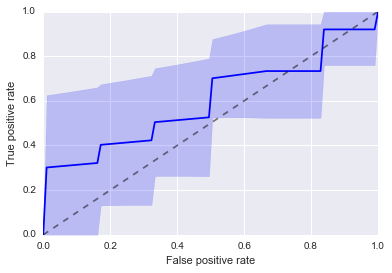

In [18]:
plot_auc_from_list(results['tpr_list'], results['mean_fpr'])

In [19]:
print(fisher_exact(results['conf_mat']))
results['conf_mat']

(2.3333333333333335, 0.1794482149812395)


,pred 0,pred 1
true 0,21,9
true 1,14,14


### Presence/absence of bal-oropharynx OTUs in BAL

In [20]:
X_pres = (X > 0).astype(int)
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

results = cv_and_roc(rf, X_pres, Y, random_state=random_state)

In [21]:
np.mean(results['auc_list'])

0.69611111111111112

In [22]:
print(fisher_exact(results['conf_mat']))
results['conf_mat']

(4.615384615384615, 0.013241431261106402)


,pred 0,pred 1
true 0,24,6
true 1,13,15


## Asp vs. non-asp, oropharyngeal microbiome, bal-throat exchanged OTUs only

In [23]:
# Throat samples only, bal-throat OTUs only
h_smpls = meta\
    .query('subject_id == @h_subjs')\
    .query('site == "throat_swab"')\
    .index.tolist()
asp_smpls = meta\
    .query('subject_id == @asp_subjs')\
    .query('site == "throat_swab"')\
    .index.tolist()

X = otu.loc[h_smpls + asp_smpls, :]
Y = [aspdict[meta.loc[i, 'mbs_consolidated']] for i in X.index]
X = X.values

rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
results = cv_and_roc(rf, X, Y, random_state=random_state)

In [24]:
# Mean AUC
np.mean(results['auc_list'])

0.53722222222222227

In [25]:
print(fisher_exact(results['conf_mat']))
results['conf_mat']

(1.1176470588235294, 1.0)


,pred 0,pred 1
true 0,19,11
true 1,17,11


### Presence/absence of bal-oropharyngeal OTUs in oropharynx

In [26]:
X_pres = (X > 0).astype(int)
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

results = cv_and_roc(rf, X_pres, Y, random_state=random_state)

In [27]:
np.mean(results['auc_list'])

0.47055555555555556

In [28]:
print(fisher_exact(results['conf_mat']))
results['conf_mat']

(0.65625, 0.44517969106540722)


,pred 0,pred 1
true 0,14,16
true 1,16,12


## Asp vs. non-asp, BAL and oropharyngeal microbiomes, bal-throat exchanged OTUs only

In [29]:
mbscol = 'mbs_consolidated'
tidyotu = tidyfy_otu(otu, meta, mbscol)

site1 = 'bal'
site2 = 'throat_swab'
tmpotu = tidyotu.query('(site == @site1) | (site == @site2)')\
            .dropna(subset=[mbscol])\
            .pivot(index='subject_id', columns='otu_w_site',
                   values='abun')\
            .dropna()

Tidying data... 
Finished.


In [30]:
# Note: using how='inner' preserves the order of the left keys, so this new tmpmeta
# is in the same order as my OTU table
tmpmeta = pd.merge(tmpotu, meta[['subject_id', 'mbs_consolidated']].drop_duplicates(),  
                   left_index=True, right_on='subject_id',
                   how='inner')

In [31]:
# Sanity check that labels will match order of samples in OTU table
tmpotu.index == tmpmeta['subject_id'].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [32]:
X = tmpotu.values
Y = [aspdict[i] for i in tmpmeta['mbs_consolidated']]

In [33]:
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
results = cv_and_roc(rf, X, Y, random_state=random_state)

In [34]:
np.mean(results['auc_list'])

0.51888888888888896

In [35]:
print(fisher_exact(results['conf_mat']))
results['conf_mat']

(0.95959595959595956, 1.0)


,pred 0,pred 1
true 0,19,11
true 1,18,10


### Presence/absence of bal-oropharyngeal OTUs in both BAL and oropharynx

In [36]:
X_pres = (X > 0).astype(int)

rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

results = cv_and_roc(rf, X_pres, Y, random_state=random_state)

In [37]:
np.mean(results['auc_list'])

0.61333333333333329

In [38]:
print(fisher_exact(results['conf_mat']))
results['conf_mat']

(1.1538461538461537, 0.7992823530053087)


,pred 0,pred 1
true 0,15,15
true 1,13,15


# Aspiration classifiers based on gastric-BAL exchanged OTUs

Basically repeat all the classifiers on the gastric and BAL exchange OTUs

In [39]:
## First, look at the most differentially exchange bugs
fpreva = '../../data/analysis/prevalence.partial_corrs.nthresh10-qthresh01-rthresh0.txt'
preva = pd.read_csv(fpreva, sep='\t')

# Let's look just at the aspirator vs. non-aspirator comparisons
preva = preva.query('meta_var == "mbs_consolidated"')

# And just the bal-throat_swab comparison
preva = preva.query('site_comparison == "bal-gastric_fluid"')

print(preva.shape, preva['otu'].unique().shape)

# Pivot to get differential prevalence
diffpreva = preva.pivot(index='otu', columns='meta_val', values='prevalence_exchange')

# Sort values by differential prevalence in aspirators
diffpreva['asp_minus_nml'] = diffpreva['Aspiration/Penetration'] - diffpreva['Normal']
#diffpreva['abs_diff'] = abs(diffpreva['asp_minus_nml'])
diffpreva.sort_values(by='asp_minus_nml', ascending=False).head(10)

((96, 6), (48,))


meta_val,Aspiration/Penetration,Normal,asp_minus_nml
otu,,,
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__;d__denovo3,0.78125,0.439024,0.342226
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__;d__denovo124,0.37500,0.048780,0.326220
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__;d__denovo216,0.34375,0.073171,0.270579
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__;d__denovo7,0.78125,0.512195,0.269055
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__;d__denovo5,0.75000,0.487805,0.262195
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__;s__;d__denovo10,0.65625,0.414634,0.241616
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo17,0.59375,0.365854,0.227896
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo18,0.53125,0.317073,0.214177
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo8,0.59375,0.390244,0.203506


In [40]:
# Just as a reminder... how many patients were used for these prevalence calcs?
preva[['meta_val', 'n_patients']].drop_duplicates()

,meta_val,n_patients
48,Aspiration/Penetration,32
96,Normal,41


For the paper, I'll just show these in the supplement.

In [41]:
## Do some text manipulations to print these values out in latex table format
table = pd.concat((diffpreva.reset_index(), diffpreva.reset_index()['otu'].str.split(';', expand=True)), axis=1)

# Split OTU names to individual phyla
# Prettify results
table['family'] = table[4].str.split('f__').str[1]
table['genus'] = table[5].str.split('g__').str[1]

# Fill in empty families with order
table['family'] = table['family'].where(table['family'] != '', "Unknown " + table[3].str.split('o__').str[1])
# Fill in empty orders with "Unkown bacteria" (I checked manually that this one is unannotated all the way)
table['family'] = table['family'].where(table['family'] != 'Unknown ', "Unknown Bacteria")

# Re-format percentages
table['Aspiration/Penetration'] = table['Aspiration/Penetration'].apply(lambda x: '{:.1f}'.format(x*100))
table['Normal'] = table['Normal'].apply(lambda x: '{:.1f}'.format(x*100))
table['Difference'] = table['asp_minus_nml'].apply(lambda x: '{:.1f}'.format(x*100))

table = table.sort_values(by='asp_minus_nml', ascending=False)

col_order = ['family', 'genus', 'Aspiration/Penetration', 'Normal', 'Difference']
table = table[col_order]
print('\n'.join(table.apply(convert_to_latex, axis=1)))

Pasteurellaceae & Haemophilus & 78.1 & 43.9 & 34.2 \\ 
Neisseriaceae & Neisseria & 37.5 & 4.9 & 32.6 \\ 
Lachnospiraceae & Coprococcus & 34.4 & 7.3 & 27.1 \\ 
Pasteurellaceae & Haemophilus & 78.1 & 51.2 & 26.9 \\ 
Neisseriaceae & Neisseria & 75.0 & 48.8 & 26.2 \\ 
Prevotellaceae &  & 65.6 & 41.5 & 24.2 \\ 
Streptococcaceae & Streptococcus & 59.4 & 36.6 & 22.8 \\ 
Prevotellaceae & Prevotella & 53.1 & 31.7 & 21.4 \\ 
Fusobacteriaceae & Fusobacterium & 59.4 & 39.0 & 20.4 \\ 
Veillonellaceae & Veillonella & 46.9 & 26.8 & 20.0 \\ 
Prevotellaceae & Prevotella & 34.4 & 14.6 & 19.7 \\ 
Lachnospiraceae & Oribacterium & 34.4 & 14.6 & 19.7 \\ 
Flavobacteriaceae & Planobacterium & 28.1 & 9.8 & 18.4 \\ 
Veillonellaceae & Veillonella & 46.9 & 29.3 & 17.6 \\ 
Streptococcaceae & Streptococcus & 56.2 & 39.0 & 17.2 \\ 
Moraxellaceae & Moraxella & 43.8 & 26.8 & 16.9 \\ 
Erysipelotrichaceae & Solobacterium & 31.2 & 14.6 & 16.6 \\ 
Prevotellaceae & Prevotella & 59.4 & 43.9 & 15.5 \\ 
Micrococcaceae & Rothi

## Asp vs. non-asp, BAL microbiome, gastric-BAL OTUs

In [42]:
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'
fmeta = '../../data/clean/rosen.metadata.clean'

otu = pd.read_csv(fotu, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)

# Keep gastric-BAL OTUs only
keepotus = diffpreva.index.tolist()
otu = otu[keepotus]

# Grab patients with both BAL and gastric fluid, and aspiration status
sites = ['bal', 'gastric_fluid']
patientsamples = meta\
    .query('site == @sites')\
    .dropna(subset=['mbs_consolidated'])\
    .groupby(['mbs_consolidated', 'site', 'subject_id'])\
    .size()\
    .to_frame('n_samples')\
    .reset_index()\
    .groupby(['subject_id', 'mbs_consolidated'])\
    .size()\
    .to_frame('n_samples')\
    .reset_index()
patientsamples = patientsamples.query('n_samples == 2')

# Get separate lists for normal and aspirator *subjects*
h_subjs = patientsamples\
    .query('mbs_consolidated == "Normal"')\
    ['subject_id'].tolist()
    
asp_subjs = patientsamples\
    .query('mbs_consolidated == "Aspiration/Penetration"')\
    ['subject_id'].tolist()

# Get healthy and aspirators BAL samples
h_smpls = meta\
    .query('subject_id == @h_subjs')\
    .query('site == "bal"')\
    .index.tolist()
asp_smpls = meta\
    .query('subject_id == @asp_subjs')\
    .query('site == "bal"').index.tolist()

# Prepare data for classifiers
X = otu.loc[h_smpls + asp_smpls, :]
Y = [aspdict[meta.loc[i, 'mbs_consolidated']] for i in X.index]
X = X.values

AUC: 0.68630952381
(3.5064935064935066, 0.015843142725102399)


,pred 0,pred 1
true 0,30,11
true 1,14,18


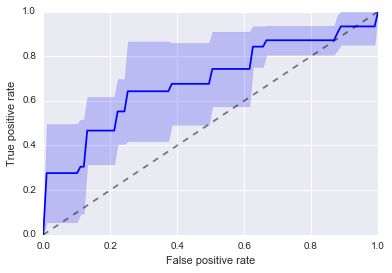

In [43]:
# Classify and print results
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
results = cv_and_roc(rf, X, Y, random_state=random_state)

print('AUC: {}'.format(np.mean(results['auc_list'])))
plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
print(fisher_exact(results['conf_mat']))
results['conf_mat']

### Presence/absence of BAL-gastric OTUs in BAL community

AUC = 0.721626984127
(4.5714285714285712, 0.0035038709635609377)


,pred 0,pred 1
true 0,32,9
true 1,14,18


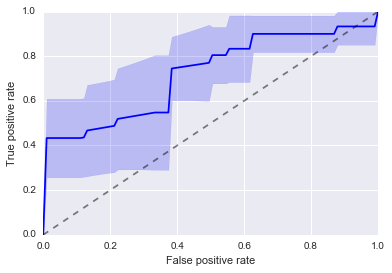

In [44]:
X_pres = (X > 0).astype(int)

rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
results_pres = cv_and_roc(rf, X_pres, Y, random_state=random_state)

print('AUC = {}'.format(np.mean(results_pres['auc_list'])))
plot_auc_from_list(results_pres['tpr_list'], results_pres['mean_fpr'])
print(fisher_exact(results_pres['conf_mat']))
results_pres['conf_mat']

## Asp vs. non-asp, gastric microbiome, gastric-BAL OTUs

In [45]:
# Get healthy and aspirators gastric samples
h_smpls = meta\
    .query('subject_id == @h_subjs')\
    .query('site == "gastric_fluid"')\
    .index.tolist()
asp_smpls = meta\
    .query('subject_id == @asp_subjs')\
    .query('site == "gastric_fluid"').index.tolist()

# Prepare data for classifiers
X = otu.loc[h_smpls + asp_smpls, :]
Y = [aspdict[meta.loc[i, 'mbs_consolidated']] for i in X.index]
X = X.values

AUC = 0.676388888889
(3.0909090909090908, 0.029671213292287446)


,pred 0,pred 1
true 0,30,11
true 1,15,17


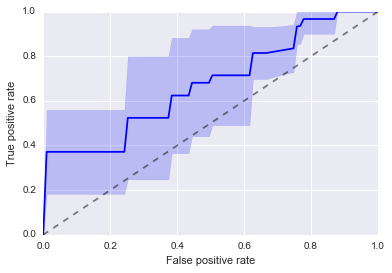

In [46]:
# Classify and print results
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
results = cv_and_roc(rf, X, Y, random_state=random_state)

print('AUC = {}'.format(np.mean(results['auc_list'])))
plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
print(fisher_exact(results['conf_mat']))
results['conf_mat']

### Presence absence of BAL-gastric OTUs in gastric community


AUC = 0.605357142857
(2.4064171122994651, 0.089711968511268239)


,pred 0,pred 1
true 0,30,11
true 1,17,15


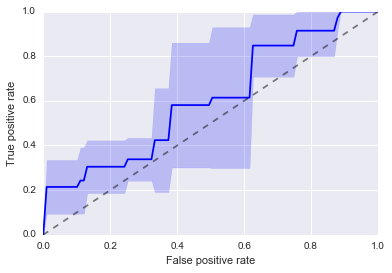

In [47]:
X_pres = (X > 0).astype(int)

rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
results_pres = cv_and_roc(rf, X_pres, Y, random_state=random_state)

print('AUC = {}'.format(np.mean(results_pres['auc_list'])))
plot_auc_from_list(results_pres['tpr_list'], results_pres['mean_fpr'])
print(fisher_exact(results_pres['conf_mat']))
results_pres['conf_mat']

## Asp vs. non-asp, BAL and gastric microbiomes, BAL-gastric OTUs

In [48]:
mbscol = 'mbs_consolidated'
tidyotu = tidyfy_otu(otu, meta, mbscol)

site1 = 'bal'
site2 = 'gastric_fluid'
tmpotu = tidyotu.query('(site == @site1) | (site == @site2)')\
            .dropna(subset=[mbscol])\
            .pivot(index='subject_id', columns='otu_w_site',
                   values='abun')\
            .dropna()

Tidying data... 
Finished.


In [49]:
# Note: using how='inner' preserves the order of the left keys, so this new tmpmeta
# is in the same order as my OTU table
tmpmeta = pd.merge(tmpotu, meta[['subject_id', 'mbs_consolidated']].drop_duplicates(),  
                   left_index=True, right_on='subject_id',
                   how='inner')
X = tmpotu.values
Y = [aspdict[i] for i in tmpmeta['mbs_consolidated']]

In [50]:
tmpotu.shape, tmpmeta.shape

((73, 96), (73, 98))

In [51]:
# Sanity check that samples are in the same order as their labels
tmpotu.index == tmpmeta['subject_id'].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

AUC = 0.67003968254
(3.5555555555555554, 0.014739536977267133)


,pred 0,pred 1
true 0,32,9
true 1,16,16


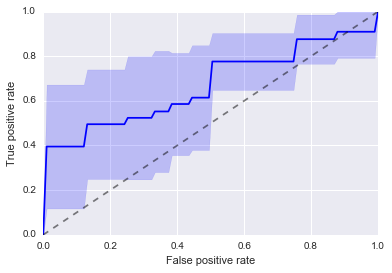

In [52]:
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
results = cv_and_roc(rf, X, Y, random_state=random_state)

print('AUC = {}'.format(np.mean(results['auc_list'])))
plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
print(fisher_exact(results['conf_mat']))
results['conf_mat']

### Presence/absence of BAL-gastric OTUs in both BAL and gastric communities

AUC = 0.657341269841
(2.4064171122994651, 0.089711968511268239)


,pred 0,pred 1
true 0,30,11
true 1,17,15


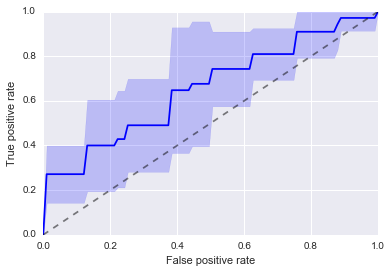

In [53]:
X_pres = (X > 0).astype(int)

rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
results_pres = cv_and_roc(rf, X_pres, Y, random_state=random_state)

print('AUC = {}'.format(np.mean(results_pres['auc_list'])))
plot_auc_from_list(results_pres['tpr_list'], results_pres['mean_fpr'])
print(fisher_exact(results_pres['conf_mat']))
results_pres['conf_mat']